In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import List, Tuple

In [2]:
draft = pd.read_csv("./draft78.csv")
seasons = pd.read_csv("./season78.csv")


##### Utility functions

In [3]:
def create_normal_distribution(size:int):
    return np.random.normal(size=size)

def convert_to_series(data: List[str]):
    return pd.Series(data=data)

def delete_features(source_dataframe: pd.DataFrame, columns: List[str], inplace=True):
    source_dataframe.drop(labels=columns, axis=1, inplace=inplace)

def df_view_is_equal_comparison(source_dataframe : pd.DataFrame, features : Tuple[str], value=0):
    return source_dataframe.loc[(source_dataframe.loc[:,features] == value)]

def df_view_is_less_comparison(source_dataframe: pd.DataFrame, features : Tuple[str], value=0):
    return source_dataframe.loc[(source_dataframe.loc[:,features] < value)]

def df_view_is_more_comparison(source_dataframe: pd.DataFrame, features: Tuple[str], value=0):
    return source_dataframe.loc[(source_dataframe.loc[:,features] > value)]

def convert_boolean_to_int(bool_value):
    return int(bool_value)


# Context

Analysts often debate about the [place of an NBA Draft class (**DC**) into the History](https://bleacherreport.com/articles/2784908-ranking-the-top-10-nba-draft-classes-of-all-time). Understanding the contribution of a DC to the NBA history seems to be paramount to observers. Which draft class is the G.O.A.T. (greatest-of-all-time), is a recurring theme. Besides pure statistics, opinions are unfortunately **biaised**, sensible to **subjectivity** : some analysts were former basketball players and teammates of NBA players,etc. The votes are not based on the offensive, defensive and overall impact but rather on which players played with whom.

## Objective

This project aims at providing leads to objectively answer this question. Several parameters will be analyzed to better understand the characteristics of a great DC. We first look at the one of the GOAT NBA draft, ask questions and explore the dataset. Then, we will look at the Win share per player and on the overall draft.

This projects is not meant to be exhaustive but rather an entry point for curious NBA enthusiasts. Other dimensions sucha as the number of championships won, the accolades, the +/- ratio must be taken into account to develop an informed viewpoint

## Feature Engineering


In [4]:
draft.dtypes

Pick        int64
Player     object
Yrs       float64
Draft       int64
dtype: object

Let's first cleanup inconsistencies about features' data types : we convert the more restrictive float64 dtype to the less restrictive int64 dtype. Having the same types for numbers will facilitate some calculations

In [5]:
def create_dataframe_given_year(source_data_frame: pd.DataFrame, features:List[str], draft_year:int):
    return source_data_frame[source_data_frame[features] == draft_year]

def convert_to_object(source_dataframe: pd.DataFrame , feature : str, new_type:str):
    source_dataframe[feature] = source_dataframe[feature].astype(new_type)
    

draft.loc[:,"Yrs"].fillna(0,inplace=True)
draft.loc[:,"Yrs"].astype("int64")
convert_to_object(draft, "Yrs", "int64")
print(f"Types of features {draft.dtypes}\n")
print(f"Features of the Draft dataframe {draft.columns}")

Types of features Pick       int64
Player    object
Yrs        int64
Draft      int64
dtype: object

Features of the Draft dataframe Index(['Pick', 'Player', 'Yrs', 'Draft'], dtype='object')


We can extract another useful information that is the retirement year for each player by summing the number of years played (*Yrs*) with the draft year (*Draft*)

In [6]:
draft["retirement_year"] = draft["Yrs"] + draft["Draft"]
draft.head()

,Pick,Player,Yrs,Draft,retirement_year
0,1,Mychal Thompson,12,1978,1990
1,2,Phil Ford,7,1978,1985
2,3,Rick Robey,8,1978,1986
3,4,Micheal Ray Richardson,8,1978,1986
4,5,Purvis Short,12,1978,1990


Let's split those players into two categories : lottery (LP) and non lottery picks (NLP). Lottery picks are players who are selected from 1st to 15th choice. Other players are considered NLPs

In [7]:
# Separates lottery pick draft
# i.e. any player who was selected in the fifteenth place or earlier from non-lottery
draft["is_lottery_pick"] = draft["Pick"] < 16
# Let's look at the information about the 16th pick in the draft dataset
# As discussed above, the component on the "is_lottery_pick" column vector should be false
print("16th pick - NLP : ", draft.iloc[15].is_lottery_pick == False)
# Quick test for the 15th pick . . .
print("15th pick - LP : ", draft.iloc[14].is_lottery_pick == True)

16th pick - NLP :  True
15th pick - LP :  True


In [8]:
# Converts boolean value into an integer
# 1, LPs
# 0, NLPS
draft.loc[:,"is_lottery_pick"] = draft.loc[:,"is_lottery_pick"].apply(func=convert_boolean_to_int)
draft.head()

,Pick,Player,Yrs,Draft,retirement_year,is_lottery_pick
0,1,Mychal Thompson,12,1978,1990,1
1,2,Phil Ford,7,1978,1985,1
2,3,Rick Robey,8,1978,1986,1
3,4,Micheal Ray Richardson,8,1978,1986,1
4,5,Purvis Short,12,1978,1990,1


We first start our analysis by looking closer to the 1984 NBA Draft, widely regarded as the best NBA Draft class (even if some analysts argue that 1985 NBA Draft is better)

You might ask yourself which critera analysts look at to determine a great DC.

Looking at [bleacher report article](https://bleacherreport.com/articles/2784908-ranking-the-top-10-nba-draft-classes-of-all-time), these parameters were taken into account:
- Players who became stars, i.e. star power and depth
- Career win shares, i.e. [player statistic which attempts to divvy up credit for team success to the individuals on the team](https://www.basketball-reference.com/about/ws.html)
    - 1 win = 1 win share
    - Offensive win share : marginal offense / marginal points per win
        - marginal offense (for a player) = points produced in a season - 0.92 * (league points per possession * number of offensive possesions)
        - League points per possession = Points produce in a season across the league / number of offensive possesions
        - marginal points per win (for a player) = 0.32 * league points per game * ((team pace / league pace))
    

In [9]:
draft_84 = create_dataframe_given_year(source_data_frame=draft, features="Draft", draft_year=1984)
draft_84.head()

,Pick,Player,Yrs,Draft,retirement_year,is_lottery_pick
1292,1,Hakeem Olajuwon,18,1984,2002,1
1293,2,Sam Bowie,10,1984,1994,1
1294,3,Michael Jordan,15,1984,1999,1
1295,4,Sam Perkins,17,1984,2001,1
1296,5,Charles Barkley,16,1984,2000,1


Selecting a subset of the original dataframe has kept the old index for the rows : first element has index 1292.
Let's re-index the dataframe so that first element has index 0

In [10]:
# Creates a new index starting from 0 to the size of the DataFrame
new_index = [number for number in range(0,len(draft_84.index))]
# inplace=True does not create a copy dataframe
draft_84.set_index(pd.Index(new_index),inplace=True)

In [11]:
draft_84.head()

,Pick,Player,Yrs,Draft,retirement_year,is_lottery_pick
0,1,Hakeem Olajuwon,18,1984,2002,1
1,2,Sam Bowie,10,1984,1994,1
2,3,Michael Jordan,15,1984,1999,1
3,4,Sam Perkins,17,1984,2001,1
4,5,Charles Barkley,16,1984,2000,1


In [12]:
player_84 = draft_84.loc[:,"Player"]
player_84

0      Hakeem Olajuwon
1            Sam Bowie
2       Michael Jordan
3          Sam Perkins
4      Charles Barkley
            ...       
223         Randy Dunn
224     Dan Pelekoudas
225        Mike Toomer
226       Martin Clark
227          Dan Trant
Name: Player, Length: 228, dtype: object

In [13]:
def extract_attributes_from_player_name(data : pd.Series):
    series_as_list = data.str.split(" ").to_list()
    # Creates a flat, uninitialized numpy array, i.e. 1D numpy array
    first_names = []
    last_names = []
    for single_player in series_as_list:
        size_of_name = len(single_player)
        first_name = single_player[0]
        if single_player[size_of_name - 1] == "II" or single_player[size_of_name - 1] == "III":
            last_name = single_player[size_of_name - 2]
        else:
            last_name  = single_player[size_of_name - 1]
        first_names.append(first_name)
        last_names.append(last_name)
    return (first_names, last_names)


We see that few players have a surname.We won't keep track of these NAs
We create two columns called "Players first name" and "Players last name" based on the Series that are processed above

In [14]:
def create_new_feature_column(source_dataframe : pd.DataFrame, column_name : str, data : pd.Series):
    ''' Creates a new column into the specified dataframe
    
    Arguments
    source_dataframe, the dataframe where the column will be inserted
    column_name, the name of the new column
    data, the values that populate the new column
    '''
    source_dataframe[column_name] = data
    

# Un-comment these cells if you want to extract both first name and last name from the Player feature

#first_names, last_names = extract_attributes_from_player_name(player_84)
#first_name_as_series = pd.Series(data=first_names)
#last_name_as_series = pd.Series(data=last_names)
#create_new_feature_column(draft_84, "players_first_name", first_name_as_series)
#create_new_feature_column(draft_84, "players_last_name", last_name_as_series)

We summarize what we did above
1. Players who are selected before the 16th place are called *lottery pick*. We extracted this feature by giving the attribute is_lottery_pick to players who have been drafter before the 16th pick.
2. We extracted both first and last name from the *Player* feature. We paid attention to players who carry the name of their fathers, i.e. players with the number of generation at the end of their names. Once the features were extracted, we got rid out of the *Player* feature
3. We converted the *Yrs* feature to a less restrictive data type, *int64*. This has facilitated the next step
4. We extracted the *retirement_year* feature by summing the *Yrs* with the Year of their draft, here 1984
5. We created the 1984 NBA Draft dataframe

## Exploratory Data Analysis (EDA)

Once the feature engineering is done, we can proceed with the EDA, that is [*an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods*](https://en.wikipedia.org/wiki/Exploratory_data_analysis).
EDA is primarly used for seeing what the data can tell us beyond the formal modeling.

Let's first look at the *Yrs* feature. I am starting by asking simple questions that descriptive statistics can easily answer:
- What is the average or median years duration in the league ?
- How tight is the spread ?
- Is there any difference between lottery and non-lottery picks ?
- Do lottery picks stay longer in the league ?
- Does being a lottery pick guarantee you a place in the NBA ?
- What is the maximum duration in the league ?
- How do the sample data look like ?

### Descriptive statistics

##### What is the average or median years duration in the league ?

- Null hypothesis (**H0**): the sample is drawn from a normal distribution
- Alternative hypothesis (**Ha**): the sample is not drawn from a normal distribution

In [15]:
from scipy import stats

def test_normal_distribution_shapiro_wilk(data: pd.Series, title : str, info=False):
    res = stats.shapiro(data)
    if info:
        print(f"Statistic: {res.statistic}")
        print(f"p-value: {res.pvalue}")
    data.plot(kind="hist", title=title)
    return res.pvalue < 0.05

Mean: 1.6403508771929824
Standard deviation: 4.00028015094374
Skweness: 2.8972655835499106
Kurtosis: 8.016463382394397

Statistic: 0.4781811833381653
p-value: 2.075667577111762e-25


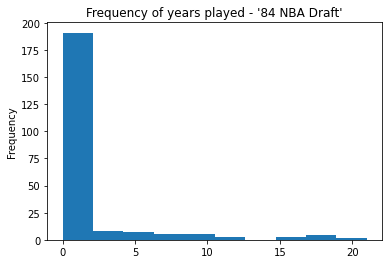

In [16]:
years = draft_84.loc[:,"Yrs"]
def compute_descriptive_statistics(data: pd.Series, charting_enabled=False, chart_title="", test_normality_info=True):
    res = stats.describe(data)
    print(f"Mean: {res.mean}\nStandard deviation: {math.sqrt(res.variance)}\nSkweness: {res.skewness}\nKurtosis: {res.kurtosis}\n")
    if charting_enabled:
        test_normal_distribution_shapiro_wilk(data, chart_title ,test_normality_info)

compute_descriptive_statistics(years, charting_enabled=True, chart_title="Frequency of years played - '84 NBA Draft'")

In [17]:
years[years > 0].count() / years.size

0.2543859649122807

Results above give us some insights, mainly:
- Data are not normally distributed
    - As discussed by the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html), the chance of rejecting the null hypothesis when it is true is close to 5% regardless of sample size). Our p-value is ~2*10^-25. This means that the observed outcome given the null hypothesis is true,  is very unlikely. We reject the null hypothesis.
    - Mean is different than 0
    - Standard Deviation is different than 0
    - Positive skewness : There is a tail on the right-end of the distribution
- The numbers of years played greatly varies : from 0 to 20 years
    - Most of the players in that year never play into the NBA
    - Few players have played in the NBA (25 %)


##### Is there any difference between lottery and non-lottery picks ?

If a player is a lottery pick, is there a difference in terms of years in the league ?

Descriptive statistics - Years in the NBA - Lottery picks
Mean: 11.733333333333333
Standard deviation: 5.700459463520295
Skweness: -0.08133207794930418
Kurtosis: -1.278220342244255

Descriptive statistics - Years in the NBA - Not lottery picks
Mean: 0.9295774647887324
Standard deviation: 2.6969091865030395
Skweness: 3.9479360293633303
Kurtosis: 17.618411894931175



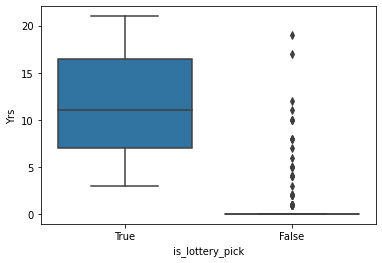

In [18]:
df_view_lottery_pick = df_view_is_equal_comparison(draft_84,"is_lottery_pick", True)
df_view_not_lottery_pick = df_view_is_equal_comparison(draft_84, "is_lottery_pick", False)
# Selects all the rows for the Yrs feature given player is a lottery pick
lottery_pick_series = df_view_lottery_pick.loc[:,"Yrs"]
# Selects all the rows for the Yrs feature given player is not a lottery pick
not_lottery_pick_series = df_view_not_lottery_pick.loc[:,"Yrs"]
print("Descriptive statistics - Years in the NBA - Lottery picks")
compute_descriptive_statistics(lottery_pick_series, charting_enabled=False)
print("Descriptive statistics - Years in the NBA - Not lottery picks")
compute_descriptive_statistics(not_lottery_pick_series, charting_enabled=False)
# Creates a boxplot to compare the distribution between LPs and NLPs
sns.boxplot(x="is_lottery_pick", y="Yrs", data=draft_84, order=[True, False]);

For NLP, there really are two players who have beaten the odds and were able to play more than the 75% of the distribution of LP ! That is an accomplishment. Who are thses two players ?

Let's have a look

In [19]:
draft_84.loc[(draft_84.loc[:,"Yrs"] > 15) & (draft_84.loc[:,"is_lottery_pick"] == False)]

,Pick,Player,Yrs,Draft,retirement_year,is_lottery_pick
15,16,John Stockton,19,1984,2003,0
45,46,Jerome Kersey,17,1984,2001,0


Unsurprisingly, one of those is an all-time-great, John Stockton:
- 10x NBA All-Star
- NBA All-Star Game MVP
- 2x All-NBA First Team
- 6x All-NBA Second Team
- 3x All-NBA Third Team
- 5x NBA All-Defensive Second Team
- 9x NBA assists leader
- 2x NBA steals leader
- NBA anniversary team

As a result, his jersey number was retired on November 22, 2004 by the only franchise he ever played for, the Utah Jazz

Results above give us some insights, mainly:
- There seems to be a significant difference for years played between non-lottery (NLP) and lottery picks (LP)
    - In constrast to NLPs, LPs play -on average- 11 years
    - In contrast to NLPs, LPs on 75th percentile is between 10-12 years : 75% of the distribution of lottery picks plays at most ~15 years
    - The minimum amount of years played by an LP is above maximum number of years for a NLP
    - Being a LP greatly increases your probability of playing. Indeed, LP have spent at least 3 years

##### Is there any relationship between being a lottery pick and the number of years played in the NBA?

NBA franchises look at several parameters to decide if a prospect is considered a LP: potential, potential fitness into the team, etc

Looking at these points, one may intuitevely think that being a LP is associated with longevity, i.e. the number of years in the NBA. Let's use the Spearman coefficient to assess the relationship between two independent variables. We use a **nonparametric** statistic because the distribution is not Gaussian (as discussed above).
X, the independent variable is the number of years played in the league while Y, the dependent variable is the lottery pick status

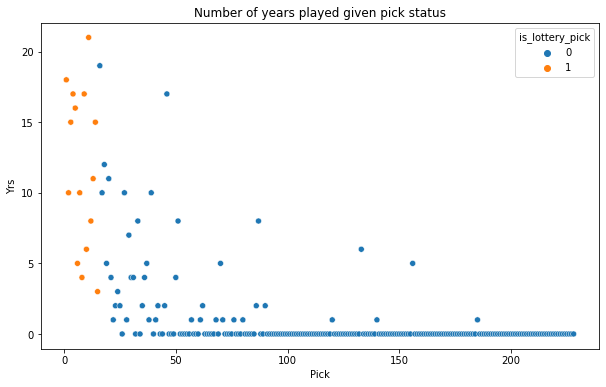

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Number of years played given pick status")
sns.scatterplot(x="Pick", y="Yrs", hue="is_lottery_pick", data=draft_84);

In [21]:
# We prefer the Spearman coefficient because it is in the same scale as the values 
spearman_coefficient = stats.spearmanr(a=draft_84["Pick"], b=draft_84["Yrs"])
print(f"Spearman coefficient: {spearman_coefficient.correlation}")

Spearman coefficient: -0.6495904412516762


- Negative coefficient : b tends to decrease when a increases
- A Spearman correlation of zero indicates that there is no tendency for b to either increase or decrease when a increases

These results are intutitive: the later the player is picked, the less likely he is a good fit for the team, consequently the less years in the nba he will be.
The coefficient tells us that the relationship between these two variables might be described by a monotonically decreasing function, i.e. function that preserves the order. For all x and y such that y ≤ x one has f ( y ) ≤ f ( x ) so f preserves the order 

##### When did most players retire ?

We want to better understand the distribution of retirement for a specific DC
One way to achieve it is to count the occurence of a year in the draft class

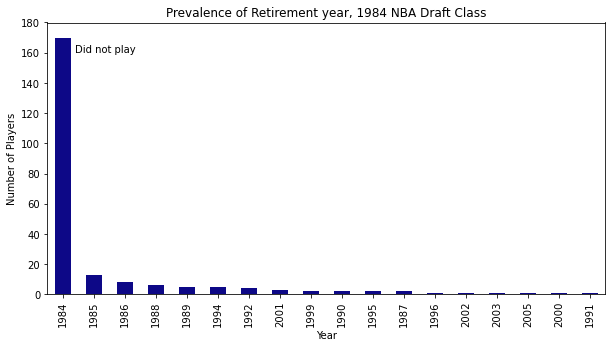

In [22]:
draft_84.loc[:,"retirement_year"].value_counts().plot.bar(xlabel="Year",
                                                          ylabel="Number of Players",
                                                          title="Prevalence of Retirement year, 1984 NBA Draft Class",
                                                         figsize=(10,5),
                                                         ylim=[0,180],
                                                         colormap="plasma");
plt.annotate("Did not play", xy=(0.4,160));

Now that we have described and understood what makes a DC great, let's have a look at [worst DC of all-time, the 2000 NBA Draft](https://bleacherreport.com/articles/734667-the-top-5-worst-nba-drafts-of-all-time).
We will use the same apporach as the 1984 NBA Draft

In [23]:
draft_00 = create_dataframe_given_year(draft, "Draft", 2000)
# Reset index
new_index = [number for number in range(0,len(draft_00.index))]
draft_00.set_index(pd.Index(new_index),inplace=True)
draft_00.head()

,Pick,Player,Yrs,Draft,retirement_year,is_lottery_pick
0,1,Kenyon Martin,15,2000,2015,1
1,2,Stromile Swift,9,2000,2009,1
2,3,Darius Miles,7,2000,2007,1
3,4,Marcus Fizer,6,2000,2006,1
4,5,Mike Miller,16,2000,2016,1


##### What is the average or median years duration in the league ?

Mean: 6.206896551724138
Standard deviation: 4.912421137047109
Skweness: 0.3668992409647038
Kurtosis: -1.072479360859562

Statistic: 0.925727367401123
p-value: 0.0016206939471885562


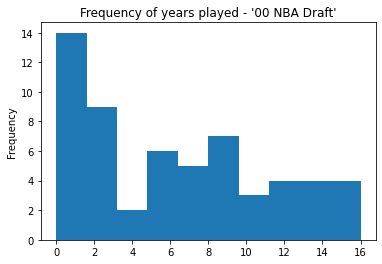

In [24]:
years_00 = draft_00.loc[:,"Yrs"]
compute_descriptive_statistics(years_00, charting_enabled=True, chart_title="Frequency of years played - '00 NBA Draft'",test_normality_info=True )

In [25]:
years_00[years > 0].count() / years_00.size

0.7413793103448276

- Distribution is not normal
    - Mean is different than 0
    - Standard Deviation is different than 1
- Most players (74.14%) of that DC played in the NBA
- Distribution is not skewed (~ 0.3)
- Player played on average 6 years

Descriptive statistics - Years in the NBA - Lottery picks
Mean: 9.2
Standard deviation: 4.3127717305695645
Skweness: 0.4227232047783495
Kurtosis: -1.189693983732931

Descriptive statistics - Years in the NBA - Not lottery picks
Mean: 5.162790697674419
Standard deviation: 4.715376228781646
Skweness: 0.5130385501373484
Kurtosis: -1.1673450483050343



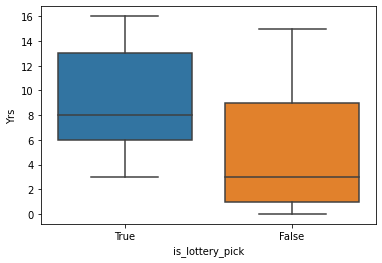

In [26]:
df_view_lottery_pick = df_view_is_equal_comparison(draft_00,"is_lottery_pick", True)
df_view_not_lottery_pick = df_view_is_equal_comparison(draft_00, "is_lottery_pick", False)
# Selects all the rows for the Yrs feature given player is a lottery pick
lottery_pick_series = df_view_lottery_pick.loc[:,"Yrs"]
# Selects all the rows for the Yrs feature given player is not a lottery pick
not_lottery_pick_series = df_view_not_lottery_pick.loc[:,"Yrs"]
print("Descriptive statistics - Years in the NBA - Lottery picks")
compute_descriptive_statistics(lottery_pick_series, charting_enabled=False)
print("Descriptive statistics - Years in the NBA - Not lottery picks")
compute_descriptive_statistics(not_lottery_pick_series, charting_enabled=False)
# Creates a boxplot to compare the distribution between LPs and NLPs
sns.boxplot(x="is_lottery_pick", y="Yrs", data=draft_00, order=[True, False]);

Results above give us some insights, mainly:
- Both populations non-lottery (NLP) and lottery picks (LP) are more homogeneous than the 1984 NBA Draft
    - There is no significant difference in the playing time given your pick status, lottery or non-lottery
    - Given by the positive skewness, outliers are located above the 75th percentile
    - Both distributions have the same spread, 4 years

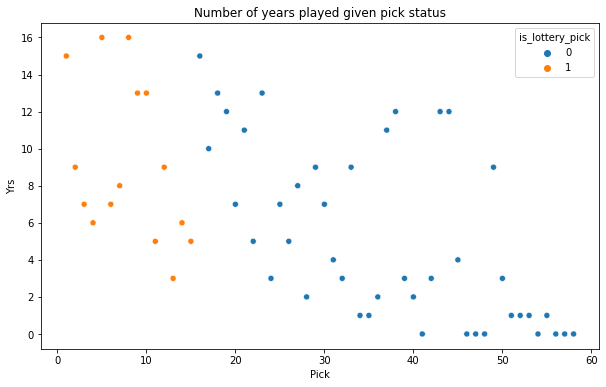

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Number of years played given pick status")
sns.scatterplot(x="Pick", y="Yrs", hue="is_lottery_pick", data=draft_00);

In [28]:
# We prefer the Spearman coefficient because it is in the same scale as the values 
spearman_coefficient = stats.spearmanr(a=draft_00["Pick"], b=draft_00["Yrs"])
print(f"Spearman coefficient: {spearman_coefficient.correlation}")

Spearman coefficient: -0.6634397439712597


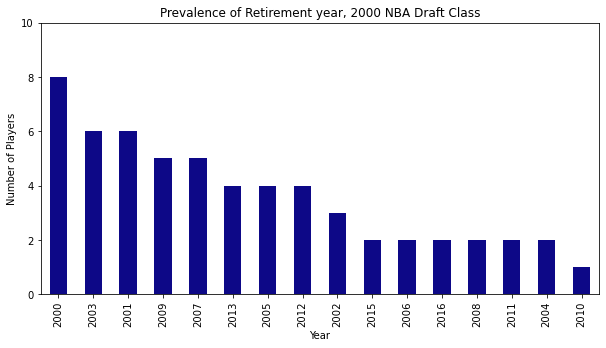

In [29]:
draft_00.loc[:,"retirement_year"].value_counts().plot.bar(xlabel="Year",
                                                          ylabel="Number of Players",
                                                          title="Prevalence of Retirement year, 2000 NBA Draft Class",
                                                         figsize=(10,5),
                                                         ylim=[0,10],
                                                         colormap="plasma");

As discussed earlier, the **Offensive Win Share** is a highly regarded statistic that tells us a lot about the impact of a player on a team

In [30]:
season_84 = create_dataframe_given_year(seasons,"Season", 1984)
season_84

,Season,Player,WS
1496,1984,Adrian Dantley*,14.6
1497,1984,Al Wood,4.4
1498,1984,Albert King,4.3
1499,1984,Alex English*,8.2
1500,1984,Allen Leavell,4.3
...,...,...,...
1800,1984,Wally Walker,0.5
1801,1984,Walter Davis,6.2
1802,1984,Wayne Cooper,4.1
1803,1984,Wes Matthews,0.4


Let's reset the index

In [31]:
# Creates a new index starting from 0 to the size of the DataFrame
new_index = [number for number in range(0,len(season_84.index))]
# inplace=True does not create a copy dataframe
season_84.set_index(pd.Index(new_index),inplace=True)
season_84.head()

,Season,Player,WS
0,1984,Adrian Dantley*,14.6
1,1984,Al Wood,4.4
2,1984,Albert King,4.3
3,1984,Alex English*,8.2
4,1984,Allen Leavell,4.3


In [32]:
df_positive_ws = df_view_is_more_comparison(season_84, "WS", 0)
df_negative_ws = df_view_is_less_comparison(season_84, "WS", 0)

In [33]:
positive_ws_series = df_positive_ws.loc[:,"WS"]
negative_ws_series = df_negative_ws.loc[:,"WS"]

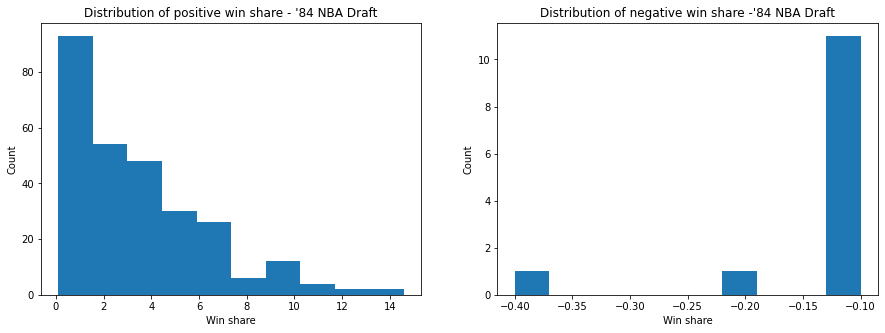

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(positive_ws_series);
ax1.set_title("Distribution of positive win share - '84 NBA Draft");
ax1.set_xlabel("Win share");
ax1.set_ylabel("Count");
ax2.hist(negative_ws_series);
ax2.set_title("Distribution of negative win share -'84 NBA Draft");
ax2.set_xlabel("Win share");
ax2.set_ylabel("Count");

Let's compute descriptive statistics for the offensive win share

In [35]:
def bin_dataframe_given_feature(source_datframe: pd.DataFrame, feature:str, threshold:int, ceiling:int):
    return source_datframe.loc[(source_datframe.loc[:,feature] < ceiling) & (source_datframe.loc[:,feature] > threshold)]

compute_descriptive_statistics(season_84.loc[:,"WS"], charting_enabled=False, test_normality_info=True)
print("Maximum value: ", season_84["WS"].max())
print("Minimum value: ", season_84["WS"].min())

Mean: 3.0524271844660196
Standard deviation: 2.9402439820640396
Skweness: 1.173554085178683
Kurtosis: 1.1423912705299175

Maximum value:  14.6
Minimum value:  -0.4


[Binning](https://en.wikipedia.org/wiki/Data_binning) WS across multiple categories may give a clearer picture and reduce the effects of minor observation errors. Let's bin WS every 2 point values

In [36]:
over_12_ws = bin_dataframe_given_feature(season_84, "WS", 12, 16).loc[:,"WS"].size
over_10_ws = bin_dataframe_given_feature(season_84, "WS", 10, 13).loc[:,"WS"].size
over_8_ws = bin_dataframe_given_feature(season_84, "WS", 8, 11).loc[:,"WS"].size
over_6_ws = bin_dataframe_given_feature(season_84, "WS", 6, 9).loc[:,"WS"].size
over_4_ws = bin_dataframe_given_feature(season_84, "WS", 4, 7).loc[:,"WS"].size
over_2_ws = bin_dataframe_given_feature(season_84, "WS", 2, 7).loc[:,"WS"].size
over_0_ws = bin_dataframe_given_feature(season_84, "WS", 0, 3).loc[:,"WS"].size
under_0_ws = bin_dataframe_given_feature(season_84, "WS", -2, 0).loc[:,"WS"].size

We want to compare the categories within a season and across decades
First let's look a the discrepancy within season.
What data gives valuable information ? 
- Number of players within the range
    - We will use a bar plot where x = categories, y = count

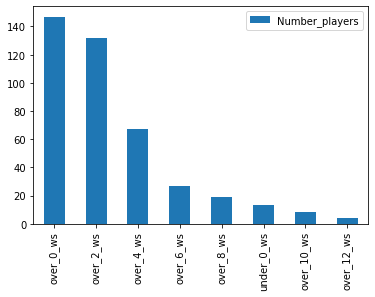

In [37]:
index = [ "over_12_ws", "over_10_ws","over_8_ws","over_6_ws", "over_4_ws","over_2_ws","over_0_ws", "under_0_ws"]
data = [over_12_ws, over_10_ws, over_8_ws, over_6_ws, over_4_ws, over_2_ws, over_0_ws, under_0_ws]

df_ws_84 = pd.DataFrame(data=data, index=index, columns=["Number_players"]).sort_values(by="Number_players", ascending=False)
df_ws_84.plot.bar();

Let's take a look at the ws change across seasons

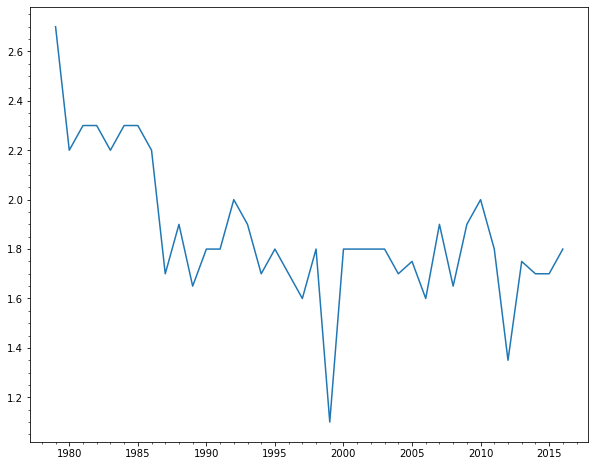

In [38]:
grouped_season = seasons.groupby("Season")
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(grouped_season.median());
ax.minorticks_on()

In [39]:
print(f"1984 NBA DC impact: {1.9/1.7}")
print(f"2000 NBA DC impact: {1.8/1.8}")

1984 NBA DC impact: 1.1176470588235294
2000 NBA DC impact: 1.0


Huge drop in '99 season due to the [1998-1999 NBA season that lasted more than 6 months](https://en.wikipedia.org/wiki/1998%E2%80%9399_NBA_lockout).
Season had to be shortened to 50 games (instead of 82 games)

Looking at the line plot above, there seems to have been 3 trend changes
1. From 1978 to 1980
2. From 1981 to 1986
3. From 1987 to 2016

The 1984 DC has an immediate impact on the league offense, as can be seen by a spike in between 1984 and 1985. This spike is a **11%** offense improvement in that year. On the other hand, on 2000-2001, the difference in offense between two seasons is constant

### Short Discussion

- Enrich the dataset with other dimensions
- Take into account playing styles (we have seen recently an explosion of the 3-Point shot while eighties basketball were more focused on favorable matchups for big men, i.e. pivots

To have a better understanding of the impact of the 84 DC (or any DC) on the NBA, one should create another dataset with all players drafted in that year, their WS on that year and over the years, **until all players in that draft retired**. This dataset would provide valuable information about:
- the impact of players in that draft
- the consistency of their offensive performances over the years
By compiling these data, we would gain more insights about the competitveness of a season, which season had the best offensive performances, etc.

Answering the question of whether a DC is the GOAT is pointless: players play in different eras, with different philosophies, training styles, medicine and nutrition. You can't compare peaches with apples. However, this project has given us a better understanding of a class of NBA players and their characteristics
